In [1]:
# Visualizacion de datos 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ML imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



# Otros
import os
from datetime import datetime

## Funciones utilizadas en este notebook

.


In [ ]:
import matplotlib.pyplot as plt

def timeplot(df, variable, titulo=None, ylabel=None):
    """
    Grafica una variable en el tiempo desde un DataFrame con índice datetime.
    
    Parámetros:
    - df: DataFrame con índice tipo Timestamp
    - variable: nombre de la columna a graficar (string)
    - titulo: (opcional) título del gráfico
    - ylabel: (opcional) etiqueta del eje Y
    """
    if variable not in df.columns:
        print(f"La variable '{variable}' no está en el DataFrame.")
        return

    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[variable], label=variable, color='tab:blue')
    plt.xlabel("Tiempo")
    plt.ylabel(ylabel if ylabel else variable)
    plt.title(titulo if titulo else f"Evolución temporal de {variable}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def heatMap(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación")
    plt.show()

In [ ]:
def boxplots(df):
    # Obtener las columnas numéricas
    cols_num = df.select_dtypes(include=['number']).columns.tolist()
    num_cols = 3  # Número de columnas en el subplot
    num_rows = (len(cols_num) + num_cols - 1) // num_cols
    
    # Crear subgráficos
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 3 * num_rows))
    fig.subplots_adjust(hspace=0.5)
    ax = ax.flatten()
    
    # Generar gráficos individuales
    for i, col in enumerate(cols_num):
        sns.boxplot(x=df[col], ax=ax[i])
        ax[i].set_title(col)
    
    # Ocultar subplots vacíos si hay un número impar de gráficos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.show()

In [2]:
def train_and_evaluate_xgboost(model, X_train, y_train, X_test, y_test, max_estimators=200):
    """
    Entrena un modelo XGBoost variando el número de estimadores y guarda las métricas.

    Retorna:
    - train_losses: lista con las pérdidas de entrenamiento
    - test_losses: lista con las pérdidas de prueba
    - test_accuracies: lista con las precisiones de prueba (R² en regresión)
    """
    train_accuracies = []
    train_losses = []
    test_losses = []
    test_accuracies = []

    for n_estimators in range(1, max_estimators + 1):
        model.set_params(n_estimators=n_estimators)
        model.fit(X_train, y_train)

        # Predicciones
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calcular métricas
        train_accuracy = r2_score(y_train, y_train_pred)
        train_loss = mean_absolute_error(y_train, y_train_pred)
        test_loss = mean_absolute_error(y_test, y_test_pred)
        test_accuracy = r2_score(y_test, y_test_pred)

        # Guardar métricas
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Imprimir progreso
        print(f"Estimators: {n_estimators}/{max_estimators}.. Tr MAE: {train_loss:.3f}.. Test MAE: {test_loss:.3f}.. tr R²: {train_accuracy:.3f}.. Test R²: {test_accuracy:.3f}")

    return train_losses, test_losses, test_accuracies, train_accuracies

def plot_training_metrics(train_losses, test_losses, test_accuracies, train_accuracies, max_estimators=200):
    """
    Grafica las métricas de entrenamiento y prueba obtenidas.

    """

    plt.figure(figsize=(8, 3))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_estimators + 1), train_losses, label='Training Loss')
    plt.plot(range(1, max_estimators + 1), test_losses, label='Test Loss')
    plt.xlabel("Estimators")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Test Loss")

    # Gráfica de precisión (R²)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_estimators + 1), test_accuracies, label='Test Accuracy (R²)', color='orange')
    plt.plot(range(1, max_estimators + 1), train_accuracies, label='Test Accuracy (R²)', color='blue')
    plt.xlabel("Estimators")
    plt.ylabel("Accuracy (R²)")
    plt.legend()
    plt.title("Test Accuracy (R²)")

    plt.tight_layout()
    plt.show()

def plot_test_predictions(y_test, y_test_pred):
    """
    Grafica las predicciones vs valores reales y los residuos en el conjunto de prueba.

    """

    # Gráfico de dispersión: Predicciones vs Valores Reales
    plt.figure(figsize=(8, 3))
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y = x)')
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs Real Values (Test Set)")
    plt.legend()
    plt.show()

    # Gráfico de residuos
    residuals = y_test - y_test_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Real Values")
    plt.ylabel("Residuals (Error)")
    plt.title("Residuals vs Real Values (Test Set)")
    plt.show()

In [3]:
def plot_all_scatter(df, y, exclude_cols=["Timestamp"]):
    """
    Genera scatter plots de todas las columnas numéricas en `df` contra `y`.

    Parámetros:
    - df (DataFrame): El DataFrame con los datos.
    - y (str): La variable dependiente.
    - exclude_cols (list): Columnas a excluir en el análisis.
    """
    # Seleccionar variables numéricas excepto las excluidas y la variable objetivo
    variables_x = [col for col in df.columns if col not in exclude_cols + [y] and df[col].dtype != 'O']
    
    if not variables_x:
        print("No hay variables numéricas para graficar.")
        return
    
    # Calcular número de filas de subplots
    filas = len(variables_x) // 3 + len(variables_x) % 3
    fig, axes = plt.subplots(filas, 3, figsize=(12, 3 * filas))
    axes = axes.flatten()

    for i, x in enumerate(variables_x):
        if df[[x, y]].dropna().empty:
            axes[i].text(0.5, 0.5, "⚠️ Datos insuficientes", fontsize=8, ha='center', va='center')
            axes[i].set_title(f"{y} vs {x}")
            axes[i].axis("off")
            continue

        axes[i].scatter(df[x], df[y], alpha=0.5, edgecolors='k')
        axes[i].grid(True, linestyle="--", alpha=0.6)
        axes[i].set_title(f"{y} vs {x}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


## Preprocesamiento


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler
from datetime import datetime

#Ruta al directorio base y del archivo Silver
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..", ".."))
SILVER_DIR = os.path.join(BASE_DIR, "data", "silver")
SILVER_FILE_PATH = os.path.join(SILVER_DIR, "silver_data.parquet")

# Cargar el dataset Silver
try:
    df_gold = pd.read_parquet(SILVER_FILE_PATH)
    print(f"Dimensiones del DataFrame: {df_gold.shape}")
    print(display(df_gold.head()))
    print("\nInformacion del DataFrame:")
    df_gold.info()
except Exception as e:
    print(f"error al cargar los datos Silver: {e}")


Dimensiones del DataFrame: (28128, 8)


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11


None

Informacion del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28128 entries, 2024-09-10 04:00:00 to 2025-06-30 03:45:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   voltaje                     28128 non-null  float64
 1   corriente_carga             28128 non-null  float64
 2   temperatura_aceite          28128 non-null  float64
 3   temperatura_ambiente        28128 non-null  float64
 4   temperatura_punto_caliente  28128 non-null  float64
 5   temperatura_burbujeo        28128 non-null  float64
 6   potencia_aparente           28128 non-null  float64
 7   tap_position                28128 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
#df_gold['hour_of_day'] = df_gold.index.hour
#df_gold['day_of_week'] = df_gold.index.dayofweek # Lunes=0, Domingo=6
df_gold['month_of_year'] = df_gold.index.month
df_gold['day_of_year'] = df_gold.index.dayofyear
#df_gold['week_of_year'] = df_gold.index.isocalendar().week.astype(int) # Necesita ser int para algunos modelos
#df_gold['is_weekend'] = (df_gold.index.dayofweek >= 5).astype(int) # 1 si es fin de semana, 0 si no
df_gold['quarter_of_year'] = df_gold.index.quarter # Trimestre del año
#ver las características temporales
print("\nPrimeras 5 filas del DataFrame Gold con características temporales:")
print(display(df_gold.tail()))



Primeras 5 filas del DataFrame Gold con características temporales:


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,month_of_year,day_of_year,quarter_of_year
timestamp,,,,,,,,,,,
2025-06-30 02:45:00,131.862888,688.338204,37.858095,16.530000,35.417641,153.104431,27.802991,8,6,181,2
2025-06-30 03:00:00,131.985069,678.283737,45.850101,20.785572,50.010959,153.163773,27.375312,8,6,181,2
2025-06-30 03:15:00,132.150829,668.648083,42.555333,19.068333,50.044694,153.223114,26.947633,8,6,181,2
2025-06-30 03:30:00,132.251691,661.406774,41.368667,19.553333,49.382498,153.282455,26.722704,8,6,181,2
2025-06-30 03:45:00,132.456340,654.233668,44.477143,21.920000,49.417194,169.409826,26.494724,8,6,181,2


None


In [6]:
# Diferencial Temperatura Aceite-Ambiente
df_gold['temp_aceite_diff_ambiente'] = df_gold['temperatura_aceite'] - df_gold['temperatura_ambiente']
# Diferencial Punto Caliente-Aceite
df_gold['punto_caliente_diff_aceite'] = df_gold['temperatura_punto_caliente'] - df_gold['temperatura_aceite']
df_gold.head()

,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,month_of_year,day_of_year,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite
timestamp,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,9,254,3,24.400000,3.753733
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,9,254,3,26.850000,5.142727
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,9,254,3,26.542857,4.965217
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,9,254,3,26.585714,4.787707
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,9,254,3,26.795238,4.610197


In [7]:

print("Calculando tasas de cambio...")
#df_gold['delta_temp_aceite_1h'] = df_gold['temperatura_aceite'].diff().rolling(window='1h').mean()
df_gold['delta_potencia_aparente_1h'] = df_gold['potencia_aparente'].diff().rolling(window='1h').mean()
#df_gold['delta_voltaje_1h'] = df_gold['voltaje'].diff().rolling(window='1h').mean()
df_gold.head(10)


Calculando tasas de cambio...


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,month_of_year,day_of_year,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite,delta_potencia_aparente_1h
timestamp,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,9,254,3,24.400000,3.753733,NaN
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,9,254,3,26.850000,5.142727,-0.513023
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,9,254,3,26.542857,4.965217,-0.510039
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,9,254,3,26.585714,4.787707,-0.527025
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,9,254,3,26.795238,4.610197,-0.533776
2024-09-10 05:15:00,130.947408,679.651644,52.871428,25.866667,57.304115,176.126086,28.242603,11,9,254,3,27.004762,4.432687,-0.497533
2024-09-10 05:30:00,131.011387,671.082906,52.714285,25.500000,57.232162,176.001775,27.921659,10,9,254,3,27.214285,4.517877,-0.451005
2024-09-10 05:45:00,131.140706,663.630621,52.557143,26.299999,56.913330,175.877464,27.625818,11,9,254,3,26.257143,4.356188,-0.384716
2024-09-10 06:00:00,131.046645,656.529251,52.400000,26.500000,56.749290,175.753153,27.324530,11,9,254,3,25.900000,4.349291,-0.321531


In [8]:

df_gold.dropna(inplace=True) # ¡Precaución! Evalúa si 0 es un valor sensato para los NaNs iniciales.

In [9]:
df_copy= df_gold.copy()  # Copia del DataFrame original para evitar problemas de referencia
# Lista de columnas a eliminar debido a alta multicolinealidad o redundancia en los datos
cols_to_drop_for_multicollinearity = [
    'corriente_carga',  # Alta correlación con corriente_carga
    'temperatura_aceite',
    'temperatura_burbujeo'
]

# Asegurarse de que las columnas existan antes de intentar eliminarlas
existing_cols_to_drop = [col for col in cols_to_drop_for_multicollinearity if col in df_copy.columns]

if existing_cols_to_drop:
    df_copy = df_copy.drop(columns=existing_cols_to_drop)
    print(f"Columnas eliminadas por multicolinealidad: {existing_cols_to_drop}")
else:
    print("No se encontraron columnas para eliminar por multicolinealidad o ya fueron eliminadas.")

print(f"Dimensiones del DataFrame después de Feature Engineering: {df_copy.shape}")
print(df_copy.head())

Columnas eliminadas por multicolinealidad: ['corriente_carga', 'temperatura_aceite', 'temperatura_burbujeo']
Dimensiones del DataFrame después de Feature Engineering: (28127, 11)
                        voltaje  temperatura_ambiente  \
timestamp                                               
2024-09-10 04:15:00  130.693073             26.650000   
2024-09-10 04:30:00  130.812457             26.800000   
2024-09-10 04:45:00  130.924854             26.600000   
2024-09-10 05:00:00  130.564417             26.233334   
2024-09-10 05:15:00  130.947408             25.866667   

                     temperatura_punto_caliente  potencia_aparente  \
timestamp                                                            
2024-09-10 04:15:00                   58.642727          30.232734   
2024-09-10 04:30:00                   58.308074          29.725678   
2024-09-10 04:45:00                   57.973421          29.164683   
2024-09-10 05:00:00                   57.638768          28.610652   
2

In [ ]:
# # Definir las columnas que no se van a escalar
# # Estas son las columnas de tiempo y 'tap_position' que no deben ser escaladas
# excluded_cols_from_scaling = [
#     'tap_position','hour_of_day', 'day_of_week', 'month_of_year', 'day_of_year',
#     'week_of_year', 'is_weekend', 'quarter_of_year', 
# ]

# # Columnas a escalar: todas las numéricas que no estén en la lista de exclusión
# # y que no sean el índice
# cols_to_scale = [col for col in df_copy.select_dtypes(include=np.number).columns if col not in excluded_cols_from_scaling]
# print(f"Columnas a escalar: {cols_to_scale}")

# if not cols_to_scale:
#     print("No se encontraron columnas numéricas para escalar. Revisa la lista de exclusión o tipos de datos.")
# else:
#     scaler = RobustScaler()
#     print(f"Escalando las siguientes columnas con RobustScaler: {cols_to_scale}")
#     df_copy[cols_to_scale] = scaler.fit_transform(df_copy[cols_to_scale])
#     print("Características escaladas con RobustScaler.")

# print("\nPrimeras 5 filas del DataFrame_copy después de escalado:")
# print(display(df_copy.head()))
# print(f"Dimensiones finales del DataFrame_copy: {df_copy.shape}")

In [10]:
from sklearn.model_selection import train_test_split

X = df_copy.drop(columns=["temperatura_punto_caliente"])
# y es la variable objetivo (precios de las viviendas)
y = df_copy["temperatura_punto_caliente"]

print(X.head())
print("y: ", y.head())

                        voltaje  temperatura_ambiente  potencia_aparente  \
timestamp                                                                  
2024-09-10 04:15:00  130.693073             26.650000          30.232734   
2024-09-10 04:30:00  130.812457             26.800000          29.725678   
2024-09-10 04:45:00  130.924854             26.600000          29.164683   
2024-09-10 05:00:00  130.564417             26.233334          28.610652   
2024-09-10 05:15:00  130.947408             25.866667          28.242603   

                     tap_position  month_of_year  day_of_year  \
timestamp                                                       
2024-09-10 04:15:00            11              9          254   
2024-09-10 04:30:00            11              9          254   
2024-09-10 04:45:00            11              9          254   
2024-09-10 05:00:00            11              9          254   
2024-09-10 05:15:00            11              9          254   

           

In [11]:
split_index = int(len(df_copy) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"X_train shape: {X_train.shape}, x_test shape: {X_test.shape}")

X_train shape: (22501, 10), x_test shape: (5626, 10)


In [ ]:
# import xgboost as xgb

# estimators = 300

# # Crear el modelo XGBoost para regresión
# params = { 
#     "n_estimators":estimators,
#     "learning_rate":0.01,
#     "gamma": 1,
#     "min_child_weight": 5,
#     "max_depth": 3,
#     "subsample":0.7,
#     "colsample_bytree": 0.7,
#     "objective":'reg:squarederror',
#     "random_state":42, 
#     "n_jobs":3
# }

# model = xgb.XGBRegressor(**params)
# # Ver la configuración por defecto
# print(model.get_params())

In [24]:
import xgboost as xgb
#Best parameters: {'colsample_bytree': np.float64(0.918855052953664), 'gamma': np.float64(1.3513802340785614), 'learning_rate': np.float64(0.07852161192407722), 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 397, 'subsample': np.float64(0.6289708138575778)}


estimators = 397

# Crear el modelo XGBoost para regresión
params = { 
    "n_estimators":estimators,
    "learning_rate":0.07852161192407722,
    "gamma": 1.3513802340785614,
    "min_child_weight": 7,
    "max_depth":3,
    "subsample":0.6289708138575778,
    "colsample_bytree": 0.918855052953664,
    "objective":'reg:squarederror',
    "random_state":42, 
    "n_jobs":3
}

model = xgb.XGBRegressor(**params)
# Ver la configuración por defecto
print(model.get_params())


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.918855052953664, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 1.3513802340785614, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.07852161192407722, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 397, 'n_jobs': 3, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6289708138575778, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [14]:
# from sklearn.model_selection import GridSearchCV

# # Definir los parámetros a ajustar
# param_grid = {
#     'learning_rate': [0.01,0.03, 0.05,0.07, 1],
#     'min_child_weight' : [5, 7],
#     'max_depth': [2, 3, 4],
#     'subsample': [0.4, 0.3, 0.5,0.7], 
#     'gamma' : [0.6, 0.8, 1],
# }
# # Crear el modelo para GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# # Entrenar con GridSearchCV
# grid_search.fit(X_train, y_train)

# # Ver los mejores parámetros encontrados
# print(f"Best parameters: {grid_search.best_params_}")
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(2, 8),
    'learning_rate': uniform(0.005, 0.1),
    'gamma': uniform(0, 2),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    n_iter=50,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)


Best parameters: {'colsample_bytree': np.float64(0.918855052953664), 'gamma': np.float64(1.3513802340785614), 'learning_rate': np.float64(0.07852161192407722), 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 397, 'subsample': np.float64(0.6289708138575778)}


In [ ]:
best_params = random_search.best_params_

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

modelos = {
    "XGBoost": xgb.XGBRegressor(**best_params),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, learning_rate=0.05, depth=7, verbose=False),
    "Ridge": Ridge(alpha=1.0)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({"Modelo": nombre, "MAE": mae, "R²": r2})

df_resultados = pd.DataFrame(resultados).sort_values(by="MAE")
print(df_resultados)


Estimators: 1/397.. Tr MAE: 6.450.. Test MAE: 8.085.. tr R²: 0.127.. Test R²: -2.058
Estimators: 2/397.. Tr MAE: 6.010.. Test MAE: 7.657.. tr R²: 0.237.. Test R²: -1.771
Estimators: 3/397.. Tr MAE: 5.608.. Test MAE: 7.254.. tr R²: 0.332.. Test R²: -1.513
Estimators: 4/397.. Tr MAE: 5.250.. Test MAE: 6.937.. tr R²: 0.410.. Test R²: -1.351
Estimators: 5/397.. Tr MAE: 4.911.. Test MAE: 6.611.. tr R²: 0.480.. Test R²: -1.162
Estimators: 6/397.. Tr MAE: 4.595.. Test MAE: 6.335.. tr R²: 0.541.. Test R²: -1.015
Estimators: 7/397.. Tr MAE: 4.307.. Test MAE: 6.037.. tr R²: 0.594.. Test R²: -0.853
Estimators: 8/397.. Tr MAE: 4.040.. Test MAE: 5.811.. tr R²: 0.640.. Test R²: -0.738
Estimators: 9/397.. Tr MAE: 3.800.. Test MAE: 5.474.. tr R²: 0.679.. Test R²: -0.572
Estimators: 10/397.. Tr MAE: 3.575.. Test MAE: 5.237.. tr R²: 0.714.. Test R²: -0.469
Estimators: 11/397.. Tr MAE: 3.371.. Test MAE: 5.026.. tr R²: 0.744.. Test R²: -0.380
Estimators: 12/397.. Tr MAE: 3.189.. Test MAE: 4.836.. tr R²: 0

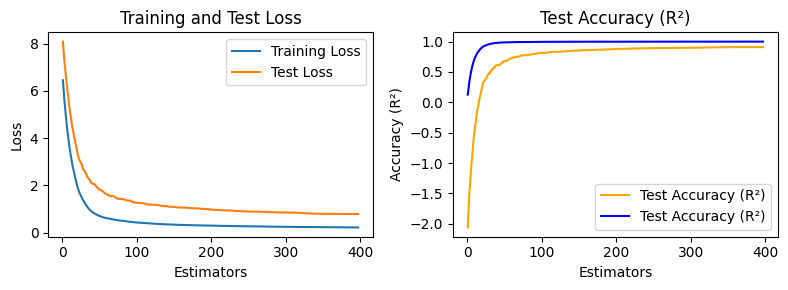

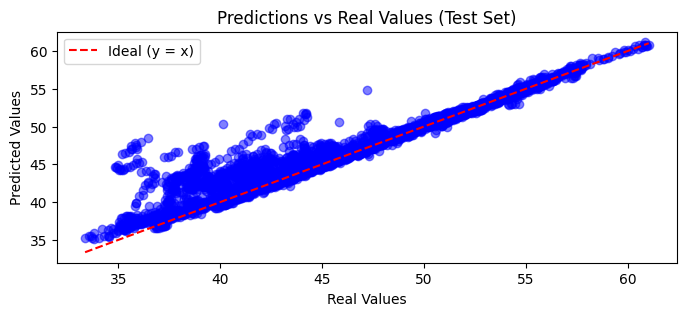

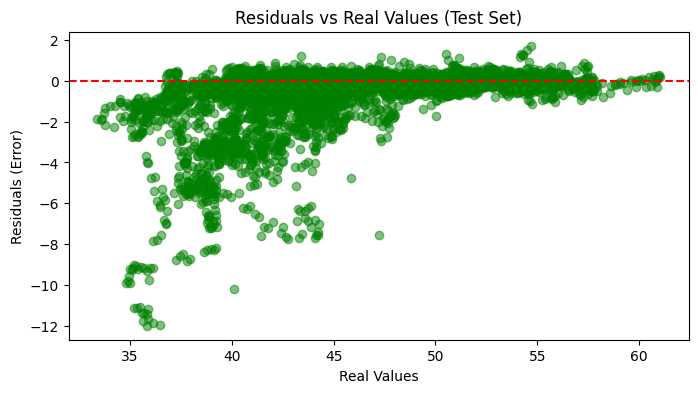

In [ ]:
# Entrenar y obtener métricas
train_losses, test_losses, test_accuracies, train_accuracies = train_and_evaluate_xgboost(model, X_train, y_train, X_test, y_test, max_estimators=estimators)

# Graficar métricas
plot_training_metrics(train_losses, test_losses, test_accuracies, train_accuracies, max_estimators=estimators)



# Hacer predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Graficar predicciones vs reales
plot_test_predictions(y_test, y_test_pred)

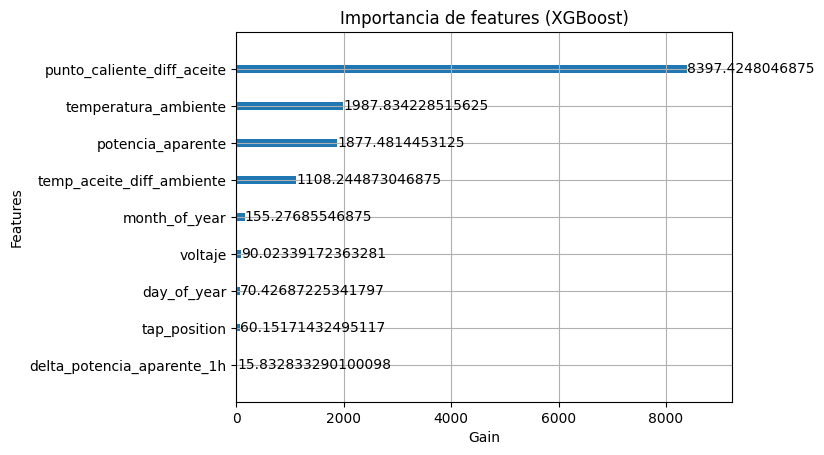

In [19]:
xgb.plot_importance(model, importance_type='gain', xlabel='Gain')
plt.title("Importancia de features (XGBoost)")
plt.show()

In [20]:
y_test_array = y_test.values.ravel()
y_test_pred

array([49.758915, 49.91566 , 50.040867, ..., 51.11098 , 50.821056,
       48.911633], dtype=float32)

In [21]:
y_test_pred

array([49.758915, 49.91566 , 50.040867, ..., 51.11098 , 50.821056,
       48.911633], dtype=float32)

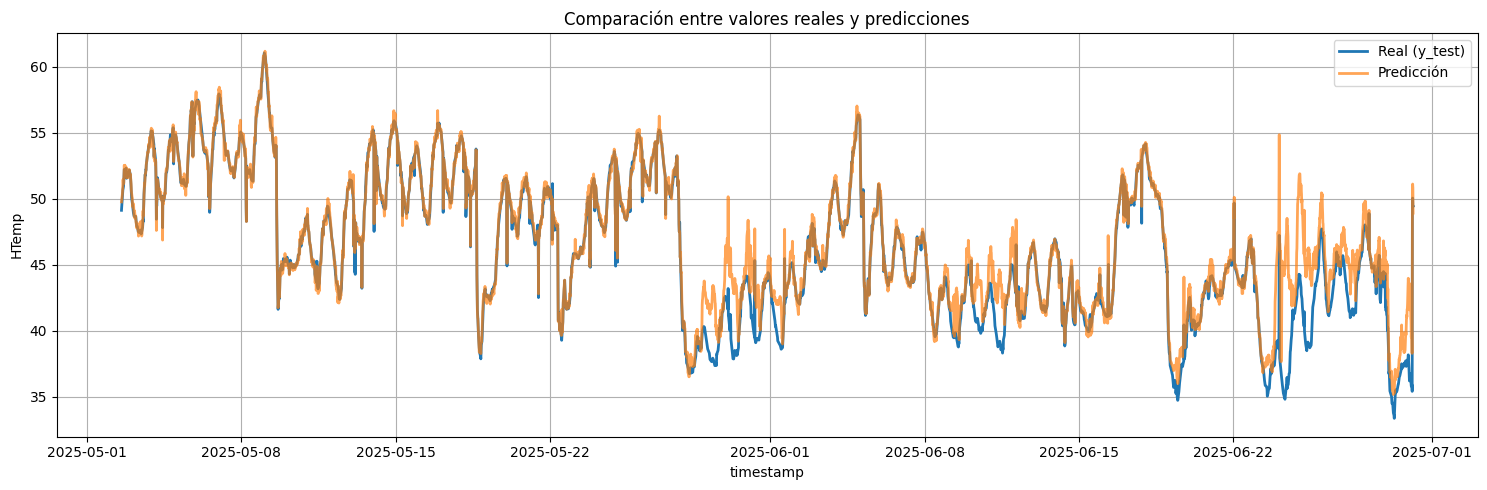

In [22]:
# Crear la figura
plt.figure(figsize=(15, 5))
plt.plot(y_test, label="Real (y_test)", linewidth=2)
plt.plot(y_test.index, y_test_pred, label="Predicción", linewidth=2, alpha=0.7)
plt.title("Comparación entre valores reales y predicciones")
plt.xlabel("timestamp")
plt.ylabel("HTemp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

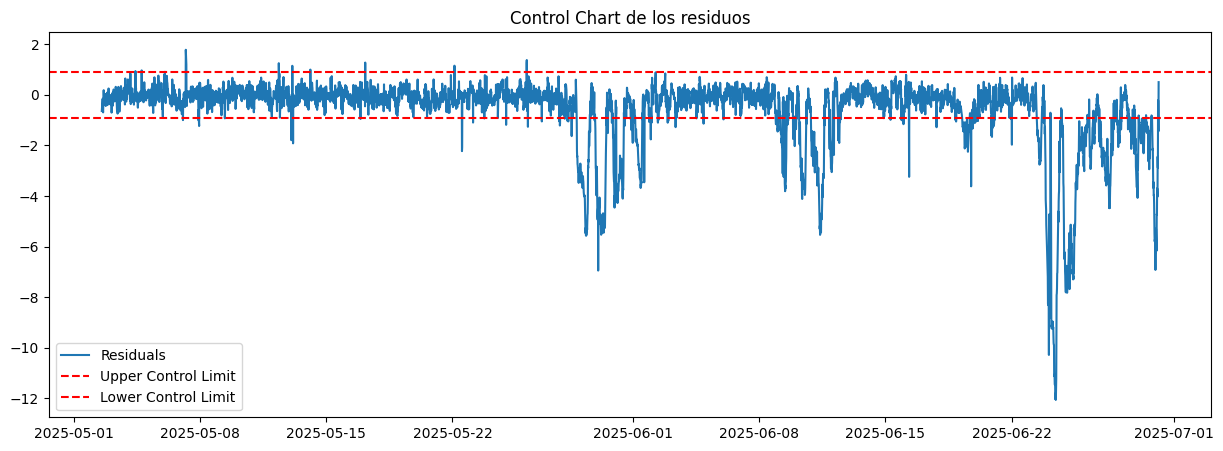

In [23]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred  # o np.abs(y_test - y_pred) si quieres usar error absoluto

# En entrenamiento
y_train_pred = model.predict(X_train)
train_residuals = y_train - y_train_pred

mean_res = np.mean(train_residuals)
std_res = np.std(train_residuals)

# Límites de control
ucl = mean_res + 3 * std_res  # Upper Control Limit
lcl = mean_res - 3 * std_res  # Lower Control Limit

anomalies = (residuals > ucl) | (residuals < lcl)

# Etiqueta: 1 = falla, 0 = normal
labels = anomalies.astype(int)

plt.figure(figsize=(15, 5))
plt.plot(residuals, label="Residuals")
plt.axhline(y=ucl, color='r', linestyle='--', label="Upper Control Limit")
plt.axhline(y=lcl, color='r', linestyle='--', label="Lower Control Limit")
plt.legend()
plt.title("Control Chart de los residuos")
plt.show()
